## Library Imports, Data Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import itertools
from sklearn.metrics import silhouette_score
import networkx as nx
from collections import defaultdict
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from itertools import combinations
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices




### Data import section is slightly altered to cover any specific references to the firm

In [2]:
# Import orderlines
OrderLinesData = pd.read_csv('data/Symson Orderlines 20241121.csv', encoding='ISO-8859-1', sep=';', decimal=',')

# Import product data
Products = pd.read_csv('data/Symson Products 20241121.csv', encoding='ISO-8859-1', sep=';', decimal=',')

# Rename columns in Products
Products.rename(columns={'ProductAttributeC':'PriceChangeFrequency','ProductAttributeE':'CompetitorIntensity', 'productId':'ProductId',
                         'ProductAttributeF':'ProductType','ProductAttributeB':'Availability','ProductAttributeG':'Sustainability'}, inplace=True)

# Rename deals
OrderLinesData.rename(columns={'OrderLineAttributeD':'Deals'}, inplace=True)

## Data Processing & Attribute Creation

In [3]:
#Eliminate negative prices and returns
OrderLinesData = OrderLinesData[(OrderLinesData['PricePerUnit']>0) & (OrderLinesData['Quantity']>=1)]

In [4]:
#Drop duplicate invoice-product pairs
OrderLinesData = OrderLinesData.drop_duplicates(subset=['InvoiceId', 'ProductId'])

In [5]:
# Month
OrderLinesData['Date Month'] = pd.to_datetime(OrderLinesData['InvoiceCreationDate']).dt.to_period('M')

# Availability
Products['Availability'] = np.where(Products['Availability']=='ON STOCK                                ', 1, 0)

## Regression Data Preparation

In [6]:
# Quantity
Quantity = OrderLinesData.filter(["ProductId", "Quantity",'Date Month'])
Quantity = Quantity.groupby(["ProductId",'Date Month']).sum().reset_index()

# Price
Price = OrderLinesData.filter(['ProductId','Date Month'])
Price.drop_duplicates(inplace=True)
W_Average_Prices = OrderLinesData.groupby(['ProductId','Date Month']).apply(lambda x: np.sum(x['Quantity']*x['PricePerUnit'])/x['Quantity'].sum(), include_groups=False).reset_index(name='PricePerUnit')

In [7]:
#Number of customers
num_customers = OrderLinesData.groupby("ProductId")["CustomerId"].nunique().rename("NumCustomers").reset_index()

In [8]:
#Create first regression dataset
dfRegression = pd.merge(Quantity, W_Average_Prices, on=['ProductId','Date Month'], how='left') 
dfRegression = pd.merge(dfRegression, OrderLinesData[['ProductId','Date Month']].drop_duplicates(), on=['ProductId','Date Month'], how='left')
dfRegression = pd.merge(dfRegression, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
dfRegression = pd.merge(dfRegression, num_customers, on='ProductId', how='left')
dfRegression.dropna(inplace=True)

In [9]:
#Number of order lines
len(OrderLinesData)

545583

In [10]:
#Number of unique products
OrderLinesData["ProductId"].nunique()

9692

In [11]:
#Will work on copy of regression data
dfRegression_t = dfRegression.copy()

In [12]:
#Main product binary
dfRegression_t["MainProduct"] = np.where(dfRegression_t["ProductType"] == "HOOFDPRODUCT", 1, 0)

# KVI Work

In [13]:
# Quantity on product level
Quantity = OrderLinesData.filter(["ProductId", "Quantity"])
Quantity = Quantity.groupby(["ProductId"]).sum().reset_index()

# Price on product level
Price = OrderLinesData.filter(['ProductId'])
Price.drop_duplicates(inplace=True)
W_Average_Prices = OrderLinesData.groupby(['ProductId']).apply(lambda x: np.sum(x['Quantity']*x['PricePerUnit'])/x['Quantity'].sum(), include_groups=False).reset_index(name='PricePerUnit')

In [14]:
#Creation of product level dataset
dfSensitivity = pd.merge(Quantity, W_Average_Prices, on=['ProductId'], how='left') 
dfSensitivity = pd.merge(dfSensitivity, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
dfSensitivity = pd.merge(dfSensitivity, num_customers, on='ProductId', how='left')

In [ ]:
#Read in KVI list
KVI_Analysis = pd.read_csv('data/DATA.csv')
KVI_Analysis = KVI_Analysis[KVI_Analysis["Category"] == "KVI"]
KVI_list = KVI_Analysis["ProductId"].tolist()
dfSensitivity["KVI_dummy"] = dfSensitivity["ProductId"].isin(KVI_list).astype(int)


## KVI Clustering

In [16]:
#Work on copy
dfAllStandard = dfSensitivity.copy()

In [17]:
#Drop missing values
dfAllStandard = dfAllStandard.dropna()

In [18]:
#Calculate product purchase count and add it to dataset
product_purchase_count = OrderLinesData["ProductId"].value_counts().reset_index()
product_purchase_count.columns = ["ProductId", "PurchaseCount"]
dfAllStandard= dfAllStandard.merge(product_purchase_count, on="ProductId", how="left")

In [19]:
#Convert binary product type
dfAllStandard["ProductType"] = np.where(dfAllStandard["ProductType"] == "HOOFDPRODUCT", 1, 0)

In [20]:
#Revenue calculation
dfAllStandard["Revenue"] = dfAllStandard["Quantity"] * dfAllStandard["PricePerUnit"]

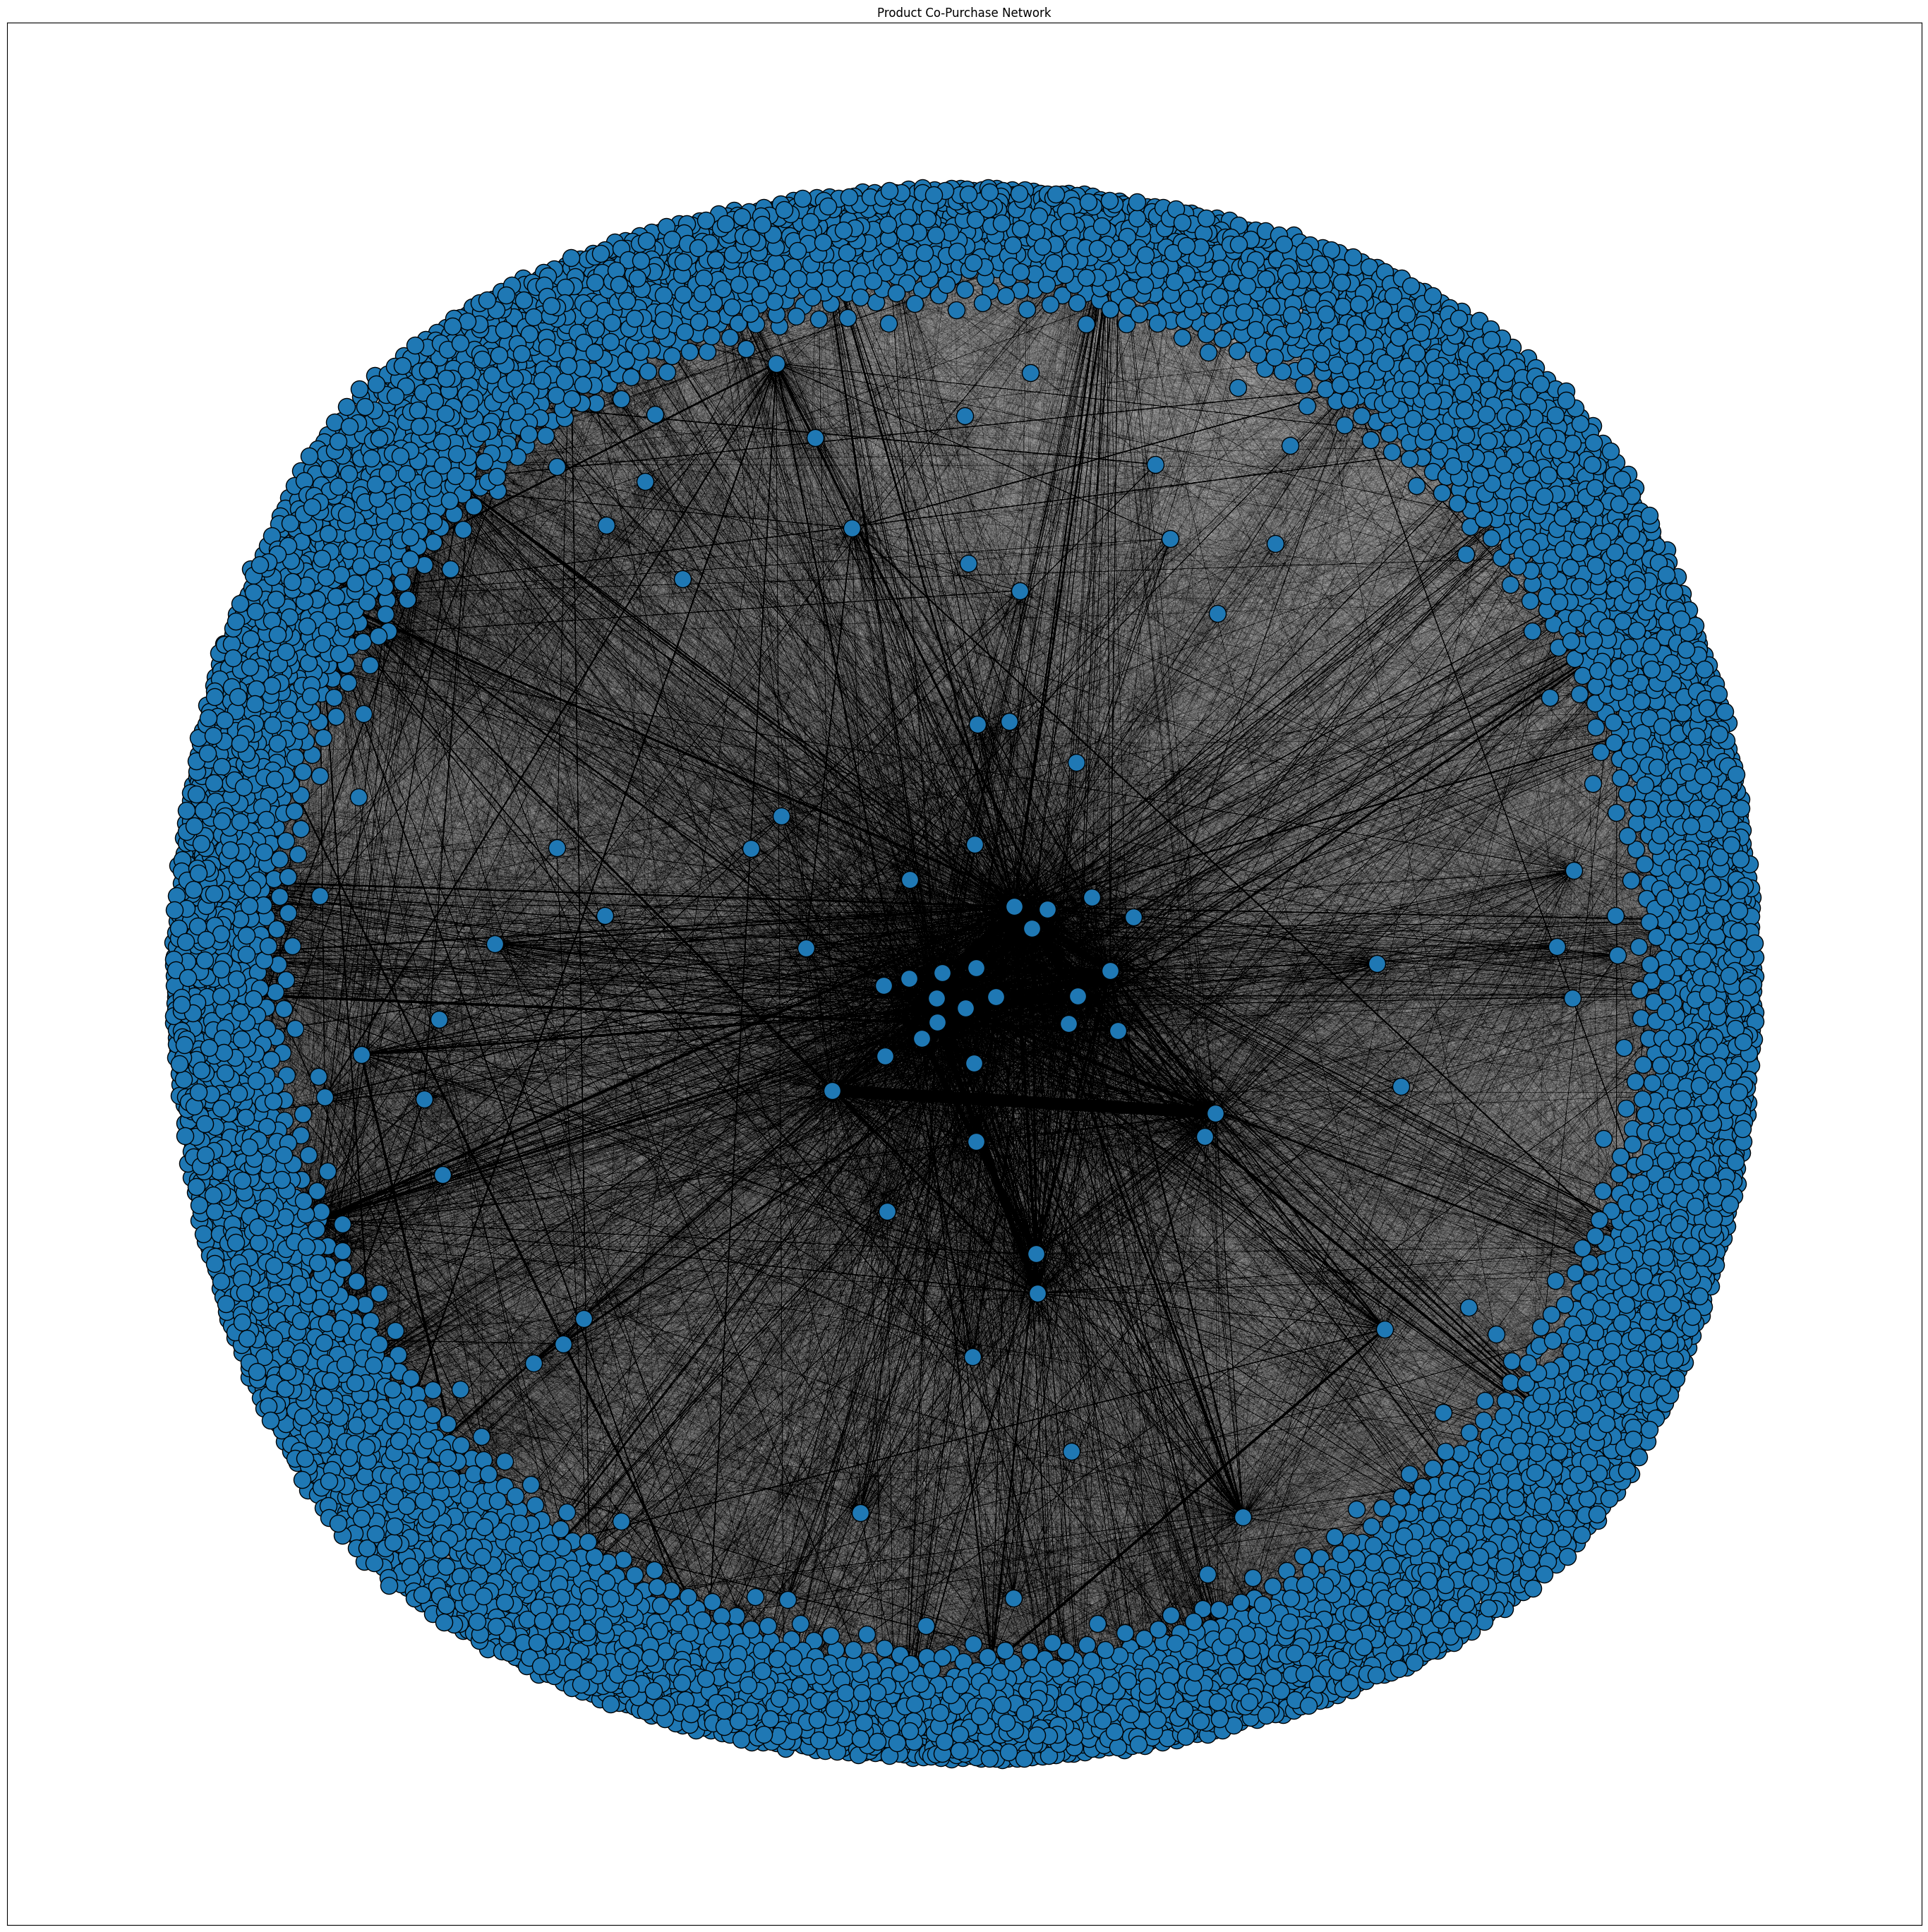

In [21]:
#Network creation


# Extract product IDs from the standard products DataFrame to focus on relevant products
df_standard_product_ids = dfAllStandard['ProductId'].tolist()

# Group order lines by InvoiceId and collect product IDs for each basket (transaction)
basket_groups = OrderLinesData.groupby('InvoiceId')['ProductId'].apply(list)

#Initialize dictionaries to store co-purchase counts and collect product IDs for each basket
co_purchase_counts = defaultdict(int)
product_counts = defaultdict(int)  

#Counting co-purchases per basket
for basket in basket_groups:
    # Filter the basket to only include standard products
    filtered_basket = [prod for prod in basket if prod in df_standard_product_ids]

    # Count co-purchases between pairs of products in the same basket
    for i in range(len(filtered_basket)):
        product_counts[filtered_basket[i]] += 1  
        for j in range(i + 1, len(filtered_basket)):
            pair = tuple(sorted([filtered_basket[i], filtered_basket[j]]))  
            co_purchase_counts[pair] += 1

#Use library to build graph (empty for now)
G = nx.Graph()

# Add edges to the graph for each co-purchase pair with their respective counts as weights
for (product1, product2), weight in co_purchase_counts.items():
    G.add_edge(product1, product2, weight=weight)

#Layout
pos = nx.spring_layout(G, seed=42, k=5) 


#Visualization details
edge_colors = []
edge_widths = []

max_weight = max(co_purchase_counts.values())

for u, v, d in G.edges(data=True):
    weight = d["weight"]
    edge_widths.append(weight / max_weight * 12)  
    

plt.figure(figsize=(35, 35))

nx.draw_networkx_nodes(G, pos, edgecolors="black")

nx.draw_networkx_edges(G, pos, alpha=1, width=edge_widths)

G.remove_edges_from(nx.selfloop_edges(G))

plt.title("Product Co-Purchase Network")
plt.show()


In [22]:
#Get degree centrality per node
degree_centrality = nx.degree_centrality(G)

In [23]:
#Add degree centrality to dataset
dfAllStandard["DegreeCentrality"] = dfAllStandard["ProductId"].map(degree_centrality)

In [24]:
#Extract betweenness centrality


#Takes 45 minutes to run, stored in csv for easier access
#betweenness_centrality = nx.betweenness_centrality(G, k=None, weight="weight")
# betweenness_centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['ProductId', 'BetweennessCentrality'])
# betweenness_centrality_df.to_csv('betweenness_centrality.csv', index=False)
betweenness_centrality_df = pd.read_csv('data/betweenness_centrality.csv')


In [25]:
#Add betweenness centrality to dataset
dfAllStandard = dfAllStandard.merge(betweenness_centrality_df, on="ProductId", how="left")

In [26]:
#Length of dataframe (also equal to number of products) lower than before
len(dfAllStandard)

8597

In [27]:
#Check for null values
dfAllStandard.isna().sum()

ProductId                   0
Quantity                    0
PricePerUnit                0
PriceChangeFrequency        0
ProductType                 0
Availability                0
NumCustomers                0
KVI_dummy                   0
PurchaseCount               0
Revenue                     0
DegreeCentrality         1329
BetweennessCentrality    1323
dtype: int64

In [28]:
#Get rid of null values (null because of no appearances in cooccurence network)
dfAllStandard = dfAllStandard.dropna()

In [29]:
#Only include products with non-zero betweenness centrality
print(len(dfAllStandard))
dfAllStandard = dfAllStandard[dfAllStandard["BetweennessCentrality"] > 0]
print(len(dfAllStandard))

7268
5586


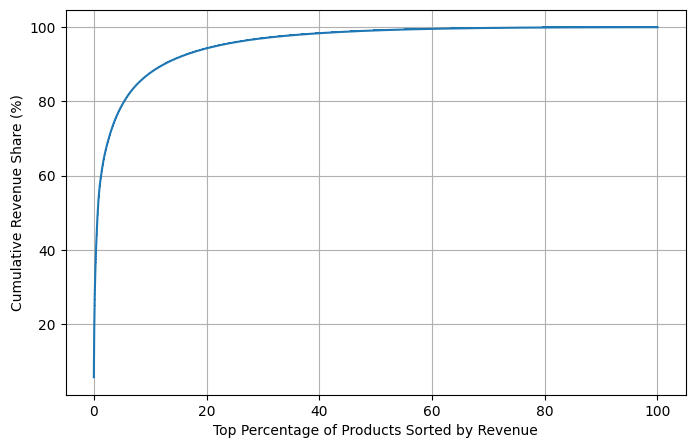

In [30]:
#Revenue pareto plot
df_sorted = dfAllStandard.sort_values(by='Revenue', ascending=False).reset_index(drop=True)

# Calculate cumulative revenue
df_sorted['CumulativeRevenue'] = df_sorted['Revenue'].cumsum()
df_sorted['CumulativeRevenue'] /= df_sorted['Revenue'].sum() 

# Calculate x-axis as percentage of products
df_sorted['ProductPercent'] = np.linspace(0, 100, len(df_sorted))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_sorted['ProductPercent'], df_sorted['CumulativeRevenue']*100, marker=',', linestyle='-')
plt.xlabel("Top Percentage of Products Sorted by Revenue")
plt.ylabel("Cumulative Revenue Share (%)")
plt.grid(True)
plt.show()

In [31]:
#Examine cut points

cut_points = [0.5, 0.8, 0.9, 0.95, 0.96, 0.97, .98]

for cp in cut_points:
    idx = df_sorted[df_sorted['CumulativeRevenue'] >= cp].index[0]
    percent_of_products = df_sorted.loc[idx, 'ProductPercent']
    print(f"{cp*100:.0f}% of revenue is generated by the top {percent_of_products:.2f}% of products.")

50% of revenue is generated by the top 0.70% of products.
80% of revenue is generated by the top 5.37% of products.
90% of revenue is generated by the top 12.44% of products.
95% of revenue is generated by the top 21.90% of products.
96% of revenue is generated by the top 25.25% of products.
97% of revenue is generated by the top 29.76% of products.
98% of revenue is generated by the top 36.45% of products.


In [32]:
#Number of products
len(df_sorted)

5586

In [33]:
#Take top 25% in terms of revenue
dfAllStandard = dfAllStandard.sort_values(by='Revenue', ascending=False).head(round(len(dfAllStandard) / 4)-1)
print(len(dfAllStandard))

1395


In [34]:
#Descriptive data

dfAllStandard[["Quantity", "PricePerUnit", "Revenue", "NumCustomers", 
               "PurchaseCount", "Availability", "PriceChangeFrequency", 
               "ProductType", "DegreeCentrality", "BetweennessCentrality"]].describe()


Quantity   PricePerUnit       Revenue  NumCustomers  PurchaseCount  \
count  1.395000e+03    1395.000000  1.395000e+03   1395.000000    1395.000000   
mean   1.201613e+04     437.621524  6.978851e+04    113.357706     322.527599   
std    5.858546e+04    5519.177039  2.872044e+05    185.985545     894.281321   
min    1.000000e+00       0.147904  4.814860e+03      1.000000       1.000000   
25%    2.822705e+02       7.434131  8.031320e+03     14.000000      22.000000   
50%    1.035000e+03      15.064192  1.477674e+04     42.000000      70.000000   
75%    4.291257e+03      42.513848  3.891976e+04    121.000000     235.000000   
max    1.339437e+06  120000.000000  5.762710e+06   1798.000000   14539.000000   

       Availability  PriceChangeFrequency  ProductType  DegreeCentrality  \
count   1395.000000           1395.000000  1395.000000       1395.000000   
mean       0.653047             11.140502     0.390681          0.038654   
std        0.476171             42.725832     0.488078          0.044845   
min        0.000000              0.000000     0.000000          0.000275   
25%        0.000000              0.000000     0.000000          0.006055   
50%        1.000000              0.000000     0.000000          0.020641   
75%        1.000000              1.500000     1.000000          0.053667   
max        1.000000            190.000000     1.000000          0.274391   

       BetweennessCentrality  
count           1.395000e+03  
mean            7.381019e-04  
std             1.197849e-03  
min             1.212720e-09  
25%             6.866866e-05  
50%             2.928910e-04  
75%             9.089740e-04  
max             1.378357e-02

In [35]:
#Log transformations
dfAllStandard["NumCustomers"] = np.log(dfAllStandard["NumCustomers"])
dfAllStandard["PurchaseCount"] = np.log(dfAllStandard["PurchaseCount"])
dfAllStandard["PricePerUnit"] = np.log(dfAllStandard["PricePerUnit"])
dfAllStandard["DegreeCentrality"] = np.log(dfAllStandard["DegreeCentrality"])
dfAllStandard["BetweennessCentrality"] = np.log(dfAllStandard["BetweennessCentrality"])
dfAllStandard["Revenue"] = np.log(dfAllStandard["Revenue"])
dfAllStandard["Quantity"] = np.log(dfAllStandard["Quantity"])


## Standard Clustering Results

In [36]:
#Robust scaling

features_to_scale = ['PricePerUnit', 'PurchaseCount', 'NumCustomers', 
                     'DegreeCentrality', 'BetweennessCentrality','Revenue', 'Quantity']

scaler = RobustScaler()

for feature in features_to_scale:
    dfAllStandard[feature + '_Scaled'] = scaler.fit_transform(dfAllStandard[[feature]])

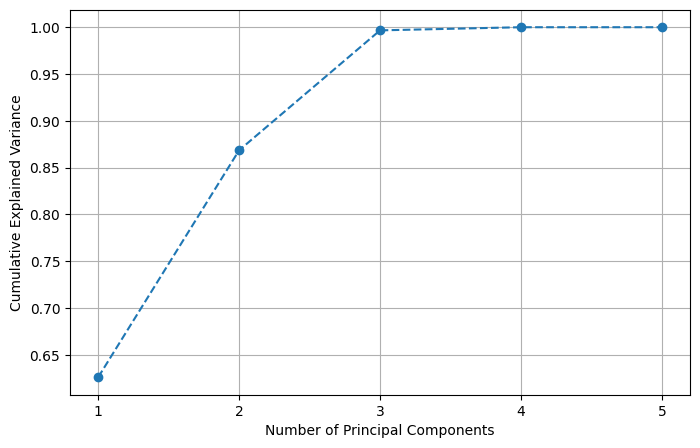

In [37]:
#Apply pca and plot scree

features = [
    'Quantity_Scaled', 'Revenue_Scaled',
    'NumCustomers_Scaled', 'PurchaseCount_Scaled', 'PricePerUnit_Scaled'
]

X = dfAllStandard[features].values  

# 1. Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# 2. Explained variance plot (Scree plot)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1)) 
plt.show()



In [38]:
pca.explained_variance_ratio_

array([0.62614563, 0.24240789, 0.12808787, 0.00335861, 0.        ])

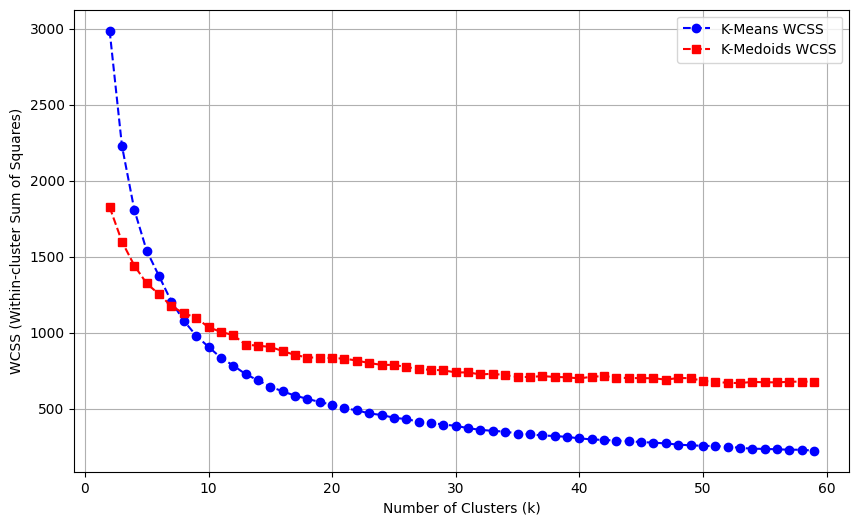

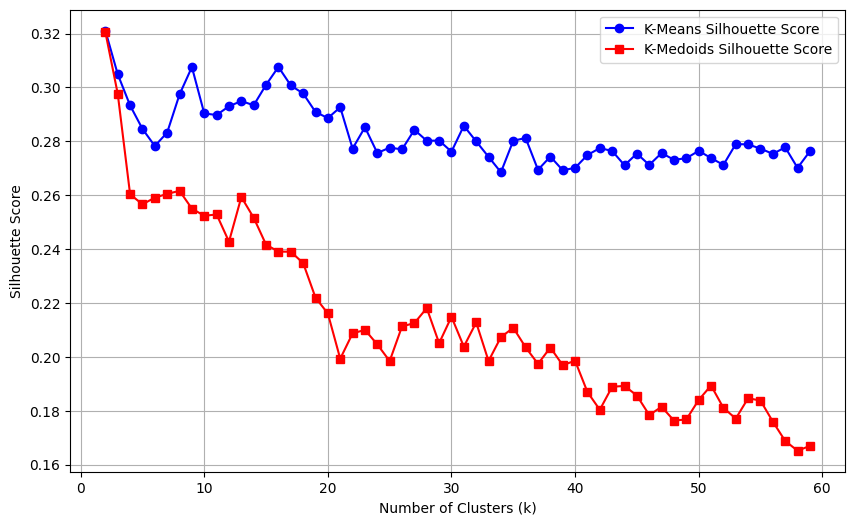

In [39]:
# Set number of components for PCA
n_components = 3

# Reduce dimensionality using PCA
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X)

# 1. Apply K-Means Clustering
wcss_kmeans = []  # Within-cluster sum of squares for K-Means
silhouette_scores_kmeans = []  # Silhouette scores for K-Means
K_range = range(2, 60)  # K-means clustering from 2 to 60 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_reduced)
    wcss_kmeans.append(kmeans.inertia_)  # WCSS for K-means
    
    # Compute silhouette score for K-means
    silhouette_avg_kmeans = silhouette_score(X_pca_reduced, kmeans.labels_)
    silhouette_scores_kmeans.append(silhouette_avg_kmeans)

# 2. Apply K-Medoids Clustering
wcss_kmedoids = []  # Within-cluster sum of squares for K-Medoids
silhouette_scores_kmedoids = []  # Silhouette scores for K-Medoids

for k in K_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X_pca_reduced)
    wcss_kmedoids.append(kmedoids.inertia_)  # WCSS for K-medoids
    
    # Compute silhouette score for K-medoids
    silhouette_avg_kmedoids = silhouette_score(X_pca_reduced, kmedoids.labels_)
    silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)

# 3. Plot WCSS for K-means and K-medoids
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss_kmeans, marker='o', linestyle='--', label='K-Means WCSS', color='blue')
plt.plot(K_range, wcss_kmedoids, marker='s', linestyle='--', label='K-Medoids WCSS', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.legend()
plt.grid(True)
plt.show()

# 4. Plot Silhouette Scores for K-means and K-medoids
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_kmeans, marker='o', linestyle='-', label='K-Means Silhouette Score', color='blue')
plt.plot(K_range, silhouette_scores_kmedoids, marker='s', linestyle='-', label='K-Medoids Silhouette Score', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
#Do clustering and get cluster details

optimal_k = 20  # Adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_reduced)

# Assign clusters to the original dataset
dfAllStandard["Cluster"] = clusters

cluster_distribution = dfAllStandard['Cluster'].value_counts(normalize=True).mul(100).round(2)
print("Cluster Size (% of Total):\n", cluster_distribution)

print(dfAllStandard["Cluster"].value_counts())

# 5. Analyze clusters by computing feature means per cluster
cluster_summary = dfAllStandard.groupby("Cluster")[features].mean()
cluster_summary.head(30)



Cluster Size (% of Total):
 Cluster
3     11.90
19     9.39
0      7.60
11     6.95
12     6.95
4      5.38
7      5.23
2      5.02
13     4.80
10     4.66
9      4.37
18     4.16
6      4.09
1      4.09
16     3.87
8      3.51
14     2.87
5      2.65
15     1.86
17     0.65
Name: proportion, dtype: float64
Cluster
3     166
19    131
0     106
11     97
12     97
4      75
7      73
2      70
13     67
10     65
9      61
18     58
6      57
1      57
16     54
8      49
14     40
5      37
15     26
17      9
Name: count, dtype: int64


Quantity_Scaled  Revenue_Scaled  NumCustomers_Scaled  \
Cluster                                                         
0              -0.370804       -0.250302             0.391910   
1               0.888570        0.313591             0.949550   
2              -1.249360       -0.295339            -0.440735   
3              -0.240600       -0.397615            -0.294597   
4               0.852930        1.153743            -0.202131   
5               0.696213       -0.207256            -1.152943   
6               1.344106        1.878298             0.898246   
7               0.086677       -0.086076            -1.109877   
8               0.068953        0.510921            -0.689017   
9              -1.756861       -0.371929            -0.974182   
10              0.469305       -0.194579             0.046202   
11              0.408938        0.879924             0.901423   
12             -0.839537       -0.299067            -0.021361   
13             -0.538261       -0.377152            -1.390863   
14              1.502051        0.582680             0.217697   
15              1.818921        2.809022             1.213493   
16             -0.462046        0.764122             0.386906   
17             -2.465990        0.634635            -1.661604   
18              0.186540       -0.166775             0.795792   
19              0.208521        0.297241             0.167793   

         PurchaseCount_Scaled  PricePerUnit_Scaled  
Cluster                                             
0                    0.379287             0.321404  
1                    1.063829            -1.133757  
2                   -0.517000             1.651806  
3                   -0.316590            -0.015128  
4                   -0.035877            -0.317767  
5                   -1.090848            -1.304931  
6                    1.102780            -0.428596  
7                   -0.962932            -0.243956  
8                   -0.613076             0.324009  
9                   -1.021564             2.374545  
10                   0.088827            -0.939323  
11                   0.959194             0.127356  
12                  -0.094067             1.008820  
13                  -1.276991             0.467951  
14                   0.313474            -1.847681  
15                   1.596707            -0.327302  
16                   0.395649             1.381895  
17                  -1.696174             4.392258  
18                   0.806987            -0.472848  
19                   0.180573            -0.087203

In [41]:
#Quick accuracy calculator
cluster= 15
print(f"{dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()}/{dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]} = {dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()/dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]}")

21/26 = 0.8076923076923077


## Full Clustering

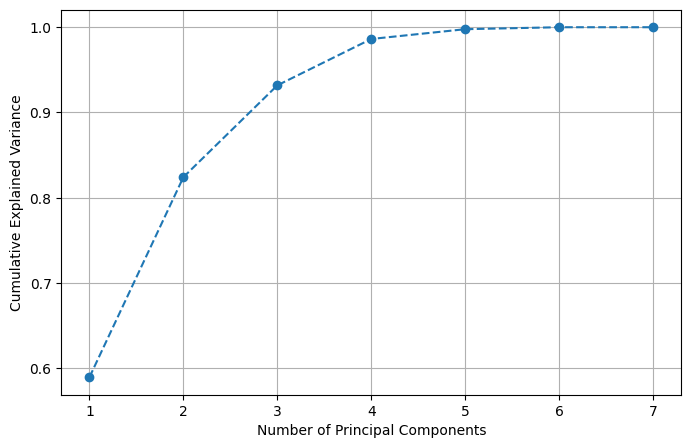

In [42]:
#PCA Scree

features = [
    'Quantity_Scaled', 'Revenue_Scaled',
    'NumCustomers_Scaled', 'PurchaseCount_Scaled', 'DegreeCentrality_Scaled', 'PricePerUnit_Scaled', 'BetweennessCentrality_Scaled'
]

X = dfAllStandard[features].values  

# 1. Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# 2. Explained variance plot (Scree plot)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1)) 
plt.show()



In [43]:
pca.explained_variance_ratio_

array([0.58949508, 0.23466471, 0.1076635 , 0.05439262, 0.0114623 ,
       0.0023218 , 0.        ])

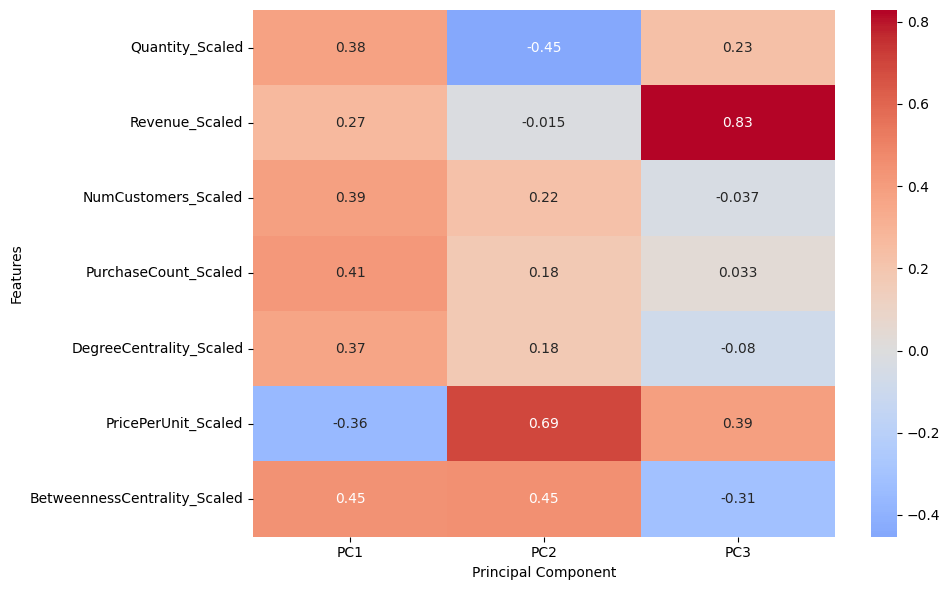

In [44]:
#Get loadings and visualize
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=features)

plt.figure(figsize=(10, 6))

# Create the heatmap
sns.heatmap(loadings[["PC1", "PC2", "PC3"]], annot=True, cmap='coolwarm', center=0)

# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Features')

# Show the plot
plt.tight_layout()
plt.show()

In [45]:
loadings

PC1       PC2       PC3       PC4  \
Quantity_Scaled               0.382936 -0.453115  0.228707  0.147723   
Revenue_Scaled                0.267307 -0.014821  0.828688  0.211486   
NumCustomers_Scaled           0.388006  0.222037 -0.036577 -0.439592   
PurchaseCount_Scaled          0.413495  0.175614  0.033100 -0.393373   
DegreeCentrality_Scaled       0.367728  0.178374 -0.080348 -0.294063   
PricePerUnit_Scaled          -0.355726  0.693762  0.393048 -0.039150   
BetweennessCentrality_Scaled  0.445663  0.448557 -0.312400  0.705310   

                                   PC5       PC6           PC7  
Quantity_Scaled               0.000358 -0.038058  7.566169e-01  
Revenue_Scaled                0.035971 -0.055480 -4.387552e-01  
NumCustomers_Scaled          -0.396998 -0.669302  4.348125e-15  
PurchaseCount_Scaled         -0.310673  0.738800 -6.157596e-15  
DegreeCentrality_Scaled       0.859327 -0.039830  2.196498e-15  
PricePerUnit_Scaled           0.031996  0.009186  4.847935e-01  
BetweennessCentrality_Scaled -0.071513  0.003413 -4.072200e-16

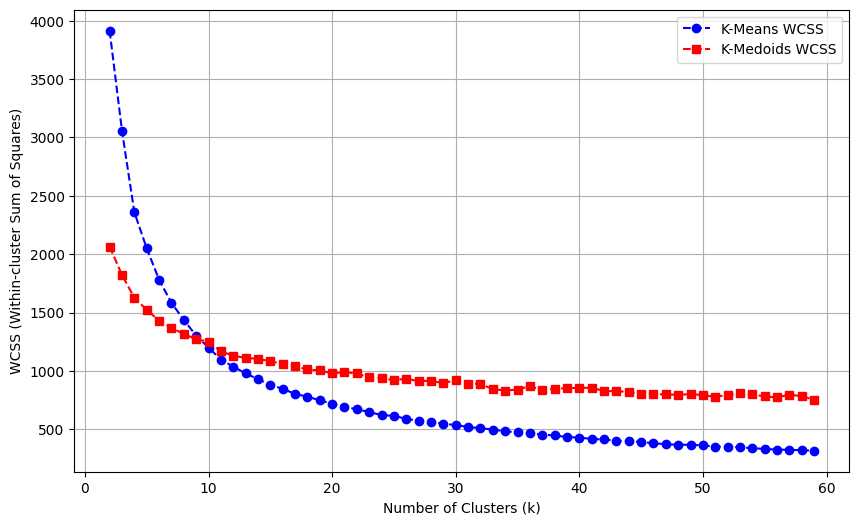

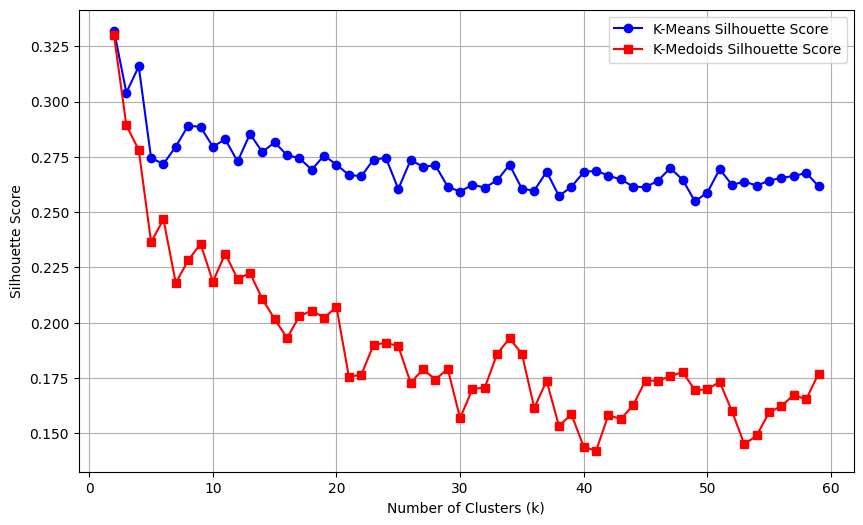

In [46]:
# Set number of components for PCA
n_components = 3

# Reduce dimensionality using PCA
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X)

# 1. Apply K-Means Clustering
wcss_kmeans = []  # Within-cluster sum of squares for K-Means
silhouette_scores_kmeans = []  # Silhouette scores for K-Means
K_range = range(2, 60)  # K-means clustering from 2 to 39 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_reduced)
    wcss_kmeans.append(kmeans.inertia_)  # WCSS for K-means
    
    # Compute silhouette score for K-means
    silhouette_avg_kmeans = silhouette_score(X_pca_reduced, kmeans.labels_)
    silhouette_scores_kmeans.append(silhouette_avg_kmeans)

# 2. Apply K-Medoids Clustering
wcss_kmedoids = []  # Within-cluster sum of squares for K-Medoids
silhouette_scores_kmedoids = []  # Silhouette scores for K-Medoids

for k in K_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X_pca_reduced)
    wcss_kmedoids.append(kmedoids.inertia_)  # WCSS for K-medoids
    
    # Compute silhouette score for K-medoids
    silhouette_avg_kmedoids = silhouette_score(X_pca_reduced, kmedoids.labels_)
    silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)

# 3. Plot WCSS for K-means and K-medoids
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss_kmeans, marker='o', linestyle='--', label='K-Means WCSS', color='blue')
plt.plot(K_range, wcss_kmedoids, marker='s', linestyle='--', label='K-Medoids WCSS', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.legend()
plt.grid(True)
plt.show()

# 4. Plot Silhouette Scores for K-means and K-medoids
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_kmeans, marker='o', linestyle='-', label='K-Means Silhouette Score', color='blue')
plt.plot(K_range, silhouette_scores_kmedoids, marker='s', linestyle='-', label='K-Medoids Silhouette Score', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()


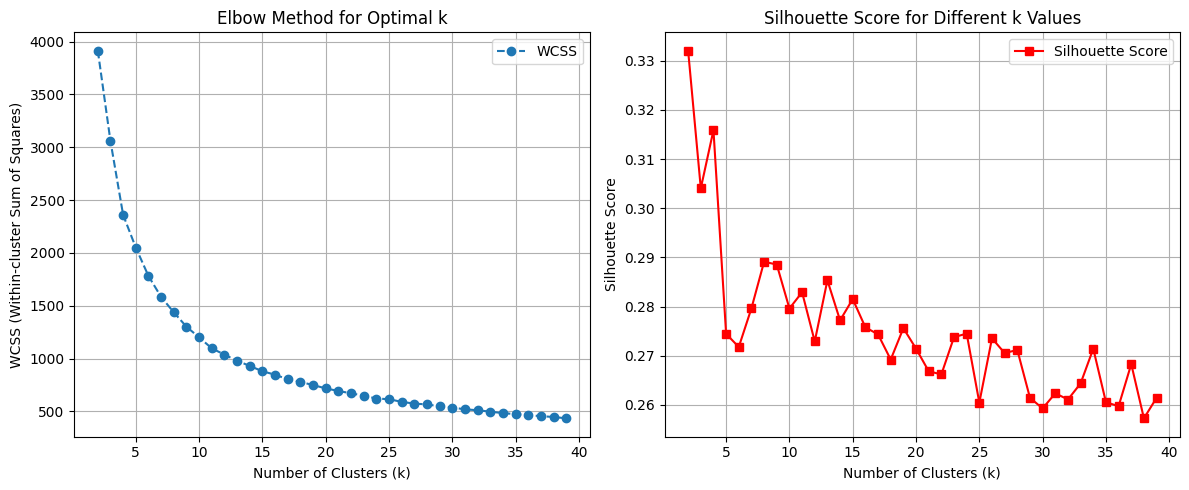

In [47]:
#Apply K-Means Clustering (Optimal k selection using Elbow Method)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []  # Silhouette scores
K_range = range(2, 40) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_reduced)
    wcss.append(kmeans.inertia_)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(X_pca_reduced, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method (WCSS)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o', linestyle='--', label='WCSS')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.legend()

# Plot the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k Values")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
#Performing clustering on optimal K and get results

optimal_k = 20  # Adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_reduced)

# Assign clusters to the original dataset
dfAllStandard["Cluster"] = clusters

cluster_distribution = dfAllStandard['Cluster'].value_counts(normalize=True).mul(100).round(2)
print("Cluster Size (% of Total):\n", cluster_distribution)

print(dfAllStandard["Cluster"].value_counts())

#Analyze clusters by computing feature means per cluster
cluster_summary = dfAllStandard.groupby("Cluster")[features].mean()
cluster_summary.head(30)



Cluster Size (% of Total):
 Cluster
0     10.04
8      9.61
1      8.53
15     7.81
5      7.74
4      6.24
9      5.52
17     5.09
7      5.02
19     5.02
6      4.59
10     4.01
12     3.87
14     3.44
16     3.01
18     2.72
13     2.29
3      2.22
11     1.65
2      1.58
Name: proportion, dtype: float64
Cluster
0     140
8     134
1     119
15    109
5     108
4      87
9      77
17     71
7      70
19     70
6      64
10     56
12     54
14     48
16     42
18     38
13     32
3      31
11     23
2      22
Name: count, dtype: int64


Quantity_Scaled  Revenue_Scaled  NumCustomers_Scaled  \
Cluster                                                         
0               0.122266        0.099090             0.477105   
1              -0.310439       -0.400163            -0.530890   
2              -2.183263        0.116039            -1.395579   
3              -0.135567       -0.127755            -1.443293   
4               0.545836        1.003341             1.037108   
5              -1.017392       -0.265800            -0.190630   
6              -0.001457       -0.100466            -0.957874   
7              -1.598071       -0.395063            -0.792265   
8              -0.037976       -0.170667            -0.084322   
9               0.493856        0.815713            -0.313228   
10              1.608440        2.431315             1.071861   
11              1.675558        0.792944             0.833466   
12             -0.429815        0.748862             0.457564   
13              0.728405        0.294875            -0.978295   
14             -0.598619       -0.321301            -1.260316   
15             -0.515680       -0.233157             0.254558   
16              0.940851        0.067196             0.089793   
17              0.964451        1.244711             0.270211   
18              0.481949       -0.299405            -0.664937   
19              0.675227        0.073241             0.877562   

         PurchaseCount_Scaled  DegreeCentrality_Scaled  PricePerUnit_Scaled  \
Cluster                                                                       
0                    0.495082                 0.406164            -0.131918   
1                   -0.529216                -0.485417             0.091564   
2                   -1.423289                -1.388915             3.481659   
3                   -1.345741                -1.602513             0.065180   
4                    1.119666                 0.791011             0.025397   
5                   -0.254690                -0.313334             1.316507   
6                   -0.851001                -0.875672            -0.119429   
7                   -0.859500                -1.096391             2.105785   
8                   -0.064608                -0.016545            -0.125968   
9                   -0.195938                -0.275726            -0.063289   
10                   1.363063                 0.839943            -0.340642   
11                   0.971607                 0.707518            -1.928177   
12                   0.437641                 0.349488             1.317782   
13                  -0.842656                -1.132282            -0.900726   
14                  -1.201872                -1.163884             0.612698   
15                   0.207087                 0.228968             0.563030   
16                   0.165523                 0.036854            -1.438348   
17                   0.402709                 0.282400            -0.409488   
18                  -0.615164                -0.621285            -1.053926   
19                   0.953843                 0.705658            -1.018317   

         BetweennessCentrality_Scaled  
Cluster                                
0                            0.333916  
1                           -0.517760  
2                           -2.606124  
3                           -3.596261  
4                            0.732446  
5                           -0.141203  
6                           -1.267525  
7                           -0.297585  
8                           -0.063343  
9                           -0.476419  
10                           0.855006  
11                           0.720598  
12                           0.472894  
13                          -2.083386  
14                          -1.979502  
15                           0.126616  
16                          -0.078214  
17                           0.127146  
18                          -0.602635  

In [49]:
cluster= 10
print(f"{dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()}/{dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]} = {dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()/dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]}")

48/56 = 0.8571428571428571


In [50]:
#Cluster sizes
for cluster in range (0, 20):
    print(len(dfAllStandard[dfAllStandard['Cluster'] == cluster]))


140
119
22
31
87
108
64
70
134
77
56
23
54
32
48
109
42
71
38
70


In [51]:
#Accuracy of each cluster
for cluster in range (0, 20):
    print(f"{dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()}/{dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]} = {dfAllStandard[dfAllStandard['Cluster'] == cluster]['KVI_dummy'].sum()/dfAllStandard[dfAllStandard['Cluster'] == cluster].shape[0]}")

26/140 = 0.18571428571428572
7/119 = 0.058823529411764705
0/22 = 0.0
2/31 = 0.06451612903225806
11/87 = 0.12643678160919541
0/108 = 0.0
8/64 = 0.125
0/70 = 0.0
15/134 = 0.11194029850746269
23/77 = 0.2987012987012987
48/56 = 0.8571428571428571
1/23 = 0.043478260869565216
0/54 = 0.0
1/32 = 0.03125
4/48 = 0.08333333333333333
3/109 = 0.027522935779816515
7/42 = 0.16666666666666666
47/71 = 0.6619718309859155
2/38 = 0.05263157894736842
9/70 = 0.12857142857142856


In [52]:
#Number of KVI list items
dfAllStandard["KVI_dummy"].sum()

214

In [53]:
#Descriptive stats of KVI list
dfAllStandard[dfAllStandard["KVI_dummy"] == 1][features].describe()

Quantity_Scaled  Revenue_Scaled  NumCustomers_Scaled  \
count       214.000000      214.000000           214.000000   
mean          0.801660        1.068800             0.287678   
std           0.661777        1.020783             0.662734   
min          -0.546336       -0.623285            -1.733024   
25%           0.272764        0.181658            -0.031426   
50%           0.777892        1.000457             0.304525   
75%           1.309764        1.757681             0.766217   
max           2.632994        3.780437             1.741875   

       PurchaseCount_Scaled  DegreeCentrality_Scaled  PricePerUnit_Scaled  \
count            214.000000               214.000000           214.000000   
mean               0.399946                 0.224342            -0.314625   
std                0.736795                 0.578077             0.360121   
min               -1.793724                -1.978723            -1.864713   
25%                0.017717                -0.040714            -0.454101   
50%                0.358160                 0.259082            -0.287181   
75%                0.946456                 0.648706            -0.066884   
max                2.252910                 1.185753             0.632170   

       BetweennessCentrality_Scaled  
count                    214.000000  
mean                       0.103104  
std                        0.792791  
min                       -4.542490  
25%                       -0.192955  
50%                        0.217356  
75%                        0.599843  
max                        1.469520

In [54]:
#Descriptive stats of non KVI list
dfAllStandard[dfAllStandard["KVI_dummy"] == 0][features].describe()

Quantity_Scaled  Revenue_Scaled  NumCustomers_Scaled  \
count      1181.000000     1181.000000          1181.000000   
mean         -0.141987        0.041438            -0.099037   
std           0.783159        0.587228             0.751615   
min          -2.550888       -0.710544            -1.733024   
25%          -0.562385       -0.441183            -0.580861   
50%          -0.110468       -0.085900            -0.071474   
75%           0.365692        0.397074             0.454775   
max           2.414978        2.663589             1.669153   

       PurchaseCount_Scaled  DegreeCentrality_Scaled  PricePerUnit_Scaled  \
count           1181.000000              1181.000000          1181.000000   
mean              -0.069084                -0.159170             0.228325   
std                0.751932                 0.713725             1.062399   
min               -1.793724                -1.978723            -2.651481   
25%               -0.550575                -0.629274            -0.360242   
50%               -0.079396                -0.058587             0.115358   
75%                0.436856                 0.403770             0.782127   
max                2.088134                 1.144159             5.151505   

       BetweennessCentrality_Scaled  
count                   1181.000000  
mean                      -0.282986  
std                        1.023361  
min                       -4.798519  
25%                       -0.635310  
50%                       -0.049403  
75%                        0.397322  
max                        1.491056

In [55]:
#Descriptive stats of top 56 by revenue KVI list
dfAllStandard[dfAllStandard["KVI_dummy"] == 1][features].sort_values("Revenue_Scaled", ascending=False).head(56).describe()

Quantity_Scaled  Revenue_Scaled  NumCustomers_Scaled  \
count        56.000000       56.000000            56.000000   
mean          1.636804        2.424423             0.909816   
std           0.359972        0.507106             0.423843   
min           0.959771        1.698546            -0.419364   
25%           1.423794        2.020090             0.691167   
50%           1.571432        2.402950             0.913785   
75%           1.865762        2.685704             1.261475   
max           2.632994        3.780437             1.741875   

       PurchaseCount_Scaled  DegreeCentrality_Scaled  PricePerUnit_Scaled  \
count             56.000000                56.000000            56.000000   
mean               1.172932                 0.722619            -0.391149   
std                0.455656                 0.305998             0.336835   
min                0.066803                -0.693931            -1.864713   
25%                0.867319                 0.604740            -0.476965   
50%                1.232368                 0.806145            -0.403709   
75%                1.430973                 0.901317            -0.210917   
max                2.252910                 1.185753             0.253765   

       BetweennessCentrality_Scaled  
count                     56.000000  
mean                       0.734377  
std                        0.343357  
min                       -0.380134  
25%                        0.546617  
50%                        0.773971  
75%                        0.958200  
max                        1.469520

In [56]:
#Cluster distribution for top 56 KVI list by revenue
dfAllStandard[dfAllStandard["KVI_dummy"] == 1].head(56)["Cluster"].value_counts()

Cluster
10    46
17     7
4      2
11     1
Name: count, dtype: int64

In [57]:
#Cluster distribution for top 56 items in general by revenue
dfAllStandard.head(56)["Cluster"].value_counts()

Cluster
10    50
17     5
9      1
Name: count, dtype: int64

In [58]:
#Cluster distribution for rest of KVI list
dfAllStandard[dfAllStandard["KVI_dummy"] == 1].iloc[56:213]["Cluster"].value_counts()

Cluster
17    40
0     26
9     23
8     15
4      9
19     9
6      8
16     7
1      6
14     4
15     3
10     2
18     2
3      2
13     1
Name: count, dtype: int64

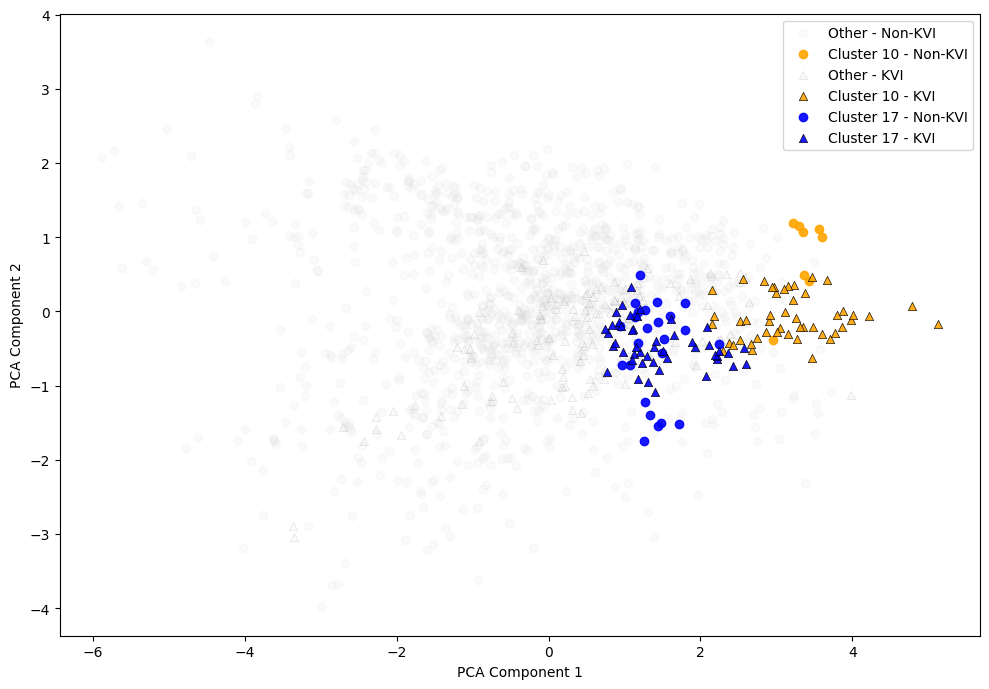

In [59]:
#Create visual

# Create masks
kvi_mask = dfAllStandard["KVI_dummy"] == 1
non_kvi_mask = ~kvi_mask
cluster_10_mask = dfAllStandard["Cluster"] == 10
non_cluster_10_mask = ~cluster_10_mask

# Use only first 2 PCA components
reduced_data_2d = X_pca_reduced[:, :2]

fig, ax = plt.subplots(figsize=(10, 7))

# Plot non-cluster 10 points (all grey)
# Circles for non-KVI
ax.scatter(reduced_data_2d[non_cluster_10_mask & non_kvi_mask, 0],
           reduced_data_2d[non_cluster_10_mask & non_kvi_mask, 1],
           color='lightgrey', alpha=0.10, label='Other - Non-KVI', marker='o')


# Plot cluster 10 points (orange)
# Circles for non-KVI
ax.scatter(reduced_data_2d[cluster_10_mask & non_kvi_mask, 0],
           reduced_data_2d[cluster_10_mask & non_kvi_mask, 1],
           color='orange', alpha=0.9, label='Cluster 10 - Non-KVI', marker='o')

# Triangles for KVI - outside cluster 10 (grey)
ax.scatter(reduced_data_2d[non_cluster_10_mask & kvi_mask, 0],
           reduced_data_2d[non_cluster_10_mask & kvi_mask, 1],
           color='lightgrey', edgecolors='black', linewidths=.5,
           alpha=0.10, label='Other - KVI', marker='^')

# Triangles for KVI - inside cluster 10 (orange)
# Triangles for KVI - inside cluster 10 (orange)
ax.scatter(reduced_data_2d[cluster_10_mask & kvi_mask, 0],
           reduced_data_2d[cluster_10_mask & kvi_mask, 1],
           color='orange', edgecolors='black', linewidths=.5,
           alpha=0.9, label='Cluster 10 - KVI', marker='^')

# Cluster 17 (blue)
cluster_17_mask = dfAllStandard["Cluster"] == 17

# Circles for non-KVI in cluster 17
ax.scatter(reduced_data_2d[cluster_17_mask & non_kvi_mask, 0],
           reduced_data_2d[cluster_17_mask & non_kvi_mask, 1],
           color='blue', alpha=0.9, label='Cluster 17 - Non-KVI', marker='o')

# Triangles for KVI in cluster 17
ax.scatter(reduced_data_2d[cluster_17_mask & kvi_mask, 0],
           reduced_data_2d[cluster_17_mask & kvi_mask, 1],
           color='blue', edgecolors='black', linewidths=.5,
           alpha=0.9, label='Cluster 17 - KVI', marker='^')

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

# Avoid duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


In [60]:
#Getting all products in cluster 10 or 17
cluster_10_17_items = dfAllStandard[dfAllStandard["Cluster"].isin([10,17])]["ProductId"].to_list()
len(cluster_10_17_items)

127

In [61]:
#Get the top two cluster in terms of 10_17 count at different levels of k
results = []
for k in [5, 8, 11, 14, 17, 20]:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters_tmp = kmeans_tmp.fit_predict(X_pca_reduced)
    df_tmp = dfAllStandard.copy()
    df_tmp["Cluster_tmp"] = clusters_tmp

    # Count how many cluster_10_17_items are in each cluster
    counts = df_tmp[df_tmp["ProductId"].isin(cluster_10_17_items)]["Cluster_tmp"].value_counts()
    top_clusters = counts.nlargest(2)
    if len(top_clusters) == 1:
        results.append((k, top_clusters.index[0], top_clusters.iloc[0], None, 0))
    else:
        results.append((k, top_clusters.index[0], top_clusters.iloc[0], top_clusters.index[1], top_clusters.iloc[1]))

for res in results:
    k, c1, n1, c2, n2 = res
    print(f"k={k}: Cluster {c1} has {n1} items, Cluster {c2} has {n2} items")


k=5: Cluster 2 has 123 items, Cluster 3 has 3 items
k=8: Cluster 4 has 68 items, Cluster 2 has 52 items
k=11: Cluster 7 has 66 items, Cluster 6 has 44 items
k=14: Cluster 8 has 66 items, Cluster 11 has 40 items
k=17: Cluster 10 has 64 items, Cluster 9 has 52 items
k=20: Cluster 17 has 71 items, Cluster 10 has 56 items


In [62]:
#Recall
# Calculate the total number of KVI_dummy = 1 rows
total_kvi = dfAllStandard[dfAllStandard['KVI_dummy'] == 1].shape[0]

# Calculate the number of KVI_dummy = 1 rows for each cluster
kvi_per_cluster = dfAllStandard[dfAllStandard['KVI_dummy'] == 1]['Cluster'].value_counts()

# Calculate the proportion of KVI_dummy = 1 rows for each cluster
kvi_proportion_per_cluster = (kvi_per_cluster / total_kvi) * 100

# Display the results
print(kvi_proportion_per_cluster)

Cluster
10    22.429907
17    21.962617
0     12.149533
9     10.747664
8      7.009346
4      5.140187
19     4.205607
6      3.738318
16     3.271028
1      3.271028
14     1.869159
15     1.401869
18     0.934579
3      0.934579
11     0.467290
13     0.467290
Name: count, dtype: float64


In [63]:
#Accuracy
# Calculate the total number of rows per cluster
total_rows_per_cluster = dfAllStandard['Cluster'].value_counts()

# Calculate the number of KVI_dummy = 1 rows per cluster
kvi_rows_per_cluster = dfAllStandard[dfAllStandard['KVI_dummy'] == 1]['Cluster'].value_counts()

# Calculate the accuracy per cluster
accuracy_per_cluster = (kvi_rows_per_cluster / total_rows_per_cluster) * 100

# Display the results
print(accuracy_per_cluster)

Cluster
0     18.571429
1      5.882353
2           NaN
3      6.451613
4     12.643678
5           NaN
6     12.500000
7           NaN
8     11.194030
9     29.870130
10    85.714286
11     4.347826
12          NaN
13     3.125000
14     8.333333
15     2.752294
16    16.666667
17    66.197183
18     5.263158
19    12.857143
Name: count, dtype: float64


### Cross-Elasticity

In [64]:
#Cross price elasticity calculation
def cross_price_elasticity(cluster_num, threshold=161):

    #Get list of product ids for the cluster of interest
    KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == cluster_num]["ProductId"].to_list()

    #Get invoices and all pairs within invoices, create pair data frame with co-occurences
    invoice_products = OrderLinesData.groupby('InvoiceId')['ProductId'].apply(list)
    pair_list = []
    for product_list in invoice_products:
        pairs = combinations(sorted(set(product_list)), 2)  # remove duplicates in invoice
        pair_list.extend(pairs)

    pair_df = pd.DataFrame(pair_list, columns=['Product_A', 'Product_B'])

    #Only include pairs with atleast one KVI cluster item and with count above the threshold
    pair_counts = pair_df.value_counts().reset_index(name='Count')
    pair_counts["KVI_A"] = pair_counts["Product_A"].isin(KVI_Cluster).astype(int)
    pair_counts["KVI_B"] = pair_counts["Product_B"].isin(KVI_Cluster).astype(int)
    pair_counts = pair_counts[pair_counts["KVI_A"] + pair_counts["KVI_B"] > 0]
    pair_counts = pair_counts[pair_counts["Count"] >= threshold]

    if len(pair_counts) == 0:
        return "No pairs"
    pd.concat([
        pd.Series(pair_counts[pair_counts["KVI_B"] == 1]["Product_B"].unique()),
        pd.Series(pair_counts[pair_counts["KVI_A"] == 1]["Product_A"].unique())
    ]).nunique()
    mask = (pair_counts["KVI_A"] == 0) & (pair_counts["KVI_B"] == 1)

    pair_counts.loc[mask, ["Product_A", "Product_B"]] = pair_counts.loc[mask, ["Product_B", "Product_A"]].values
    pair_counts.loc[mask, ["KVI_A", "KVI_B"]] = pair_counts.loc[mask, ["KVI_B", "KVI_A"]].values


    results = []

    for _, row in pair_counts.iterrows():
        prod_a = row['Product_A']
        prod_b = row['Product_B']
        
        # Get all invoices containing A
        invoices_a = OrderLinesData[OrderLinesData['ProductId'] == prod_a][['InvoiceId', 'PricePerUnit']]
        invoices_a = invoices_a.rename(columns={'PricePerUnit': 'Price_A'})

        # Get all invoices containing B
        invoices_b = OrderLinesData[OrderLinesData['ProductId'] == prod_b][['InvoiceId', 'Quantity']]
        invoices_b = invoices_b.rename(columns={'Quantity': 'Quantity_B'})
        
        # Merge on InvoiceId to get only those invoices where both appear
        merged = invoices_a.merge(invoices_b, on='InvoiceId')

        if len(merged) >= 10:
            merged = merged[(merged['Quantity_B'] > 0) & (merged['Price_A'] > 0)]

            # Log-transform
            merged['log_Q_B'] = np.log(merged['Quantity_B'])
            merged['log_P_A'] = np.log(merged['Price_A'])

            # Add constant for intercept
            X = sm.add_constant(merged['log_P_A'])
            y = merged['log_Q_B']

            # Fit regression
            # Fit regression with clustered standard errors by InvoiceId
            model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged['InvoiceId']})


            elasticity = model.params['log_P_A']
            p_value = model.pvalues['log_P_A']
            unique_prices = merged['Price_A'].nunique()
            unique_quantities = merged["Quantity_B"].nunique()
            
            results.append({
                'Product_A': prod_a,
                'Product_B': prod_b,
                'Cross_Elasticity': elasticity,
                'P_Value': p_value,
                'Num_Samples': len(merged),
                'Unique_Prices_A': unique_prices,
                'Unique_Quantities_B': unique_quantities
            })

    results_df = pd.DataFrame(results)
    pair_counts = pair_counts.merge(results_df.filter(["Product_A", "Product_B", "Cross_Elasticity", "P_Value", "Unique_Prices_A", "Unique_Quantities_B"]), on=["Product_A", "Product_B"], how="left")
    # Filter the DataFrame first
    filtered = pair_counts[(pair_counts["P_Value"] < 0.05) & (pair_counts["Unique_Prices_A"] > 10)]
    if len(filtered) == 0:
        return "No pairs"

    # Compute weighted average of Cross_Elasticity using 'Count' as weights
    weighted_avg = np.average(filtered["Cross_Elasticity"], weights=filtered["Count"])

    print(f"Cluster {cluster_num} Weighted Average Cross-Elasticity:", weighted_avg, "Average Cross-Elasticity:", filtered["Cross_Elasticity"].mean(), "Number of Pairs:", len(filtered))

for n in range(0,20):
    cross_price_elasticity(n, 161)
    

Cluster 0 Weighted Average Cross-Elasticity: -1.228007628138782 Average Cross-Elasticity: -1.3376836160897938 Number of Pairs: 16
Cluster 4 Weighted Average Cross-Elasticity: -1.3253260312883801 Average Cross-Elasticity: -1.4763978218525633 Number of Pairs: 219
Cluster 8 Weighted Average Cross-Elasticity: -0.6332573815625252 Average Cross-Elasticity: -0.6332573815625252 Number of Pairs: 1
Cluster 10 Weighted Average Cross-Elasticity: -1.305883497979097 Average Cross-Elasticity: -1.4280132291245538 Number of Pairs: 296
Cluster 11 Weighted Average Cross-Elasticity: -0.583448942158748 Average Cross-Elasticity: -0.9131769656449701 Number of Pairs: 35
Cluster 17 Weighted Average Cross-Elasticity: -1.193479608542907 Average Cross-Elasticity: -1.3981406663340006 Number of Pairs: 7
Cluster 19 Weighted Average Cross-Elasticity: -1.1715409989689098 Average Cross-Elasticity: -1.296024720056447 Number of Pairs: 70


In [65]:
#Repeat previous cell but just for the KVI list

KVI_Cluster = dfAllStandard[dfAllStandard["KVI_dummy"] == 1]["ProductId"].to_list()
invoice_products = OrderLinesData.groupby('InvoiceId')['ProductId'].apply(list)
pair_list = []
for product_list in invoice_products:
    pairs = combinations(sorted(set(product_list)), 2)  # remove duplicates in invoice
    pair_list.extend(pairs)

pair_df = pd.DataFrame(pair_list, columns=['Product_A', 'Product_B'])

pair_counts = pair_df.value_counts().reset_index(name='Count')
pair_counts["KVI_A"] = pair_counts["Product_A"].isin(KVI_Cluster).astype(int)
pair_counts["KVI_B"] = pair_counts["Product_B"].isin(KVI_Cluster).astype(int)
pair_counts = pair_counts[pair_counts["KVI_A"] + pair_counts["KVI_B"] > 0]
pair_counts = pair_counts[pair_counts["Count"] >= 161]

if len(pair_counts) == 0:
    print("No pairs")
pd.concat([
    pd.Series(pair_counts[pair_counts["KVI_B"] == 1]["Product_B"].unique()),
    pd.Series(pair_counts[pair_counts["KVI_A"] == 1]["Product_A"].unique())
]).nunique()
mask = (pair_counts["KVI_A"] == 0) & (pair_counts["KVI_B"] == 1)

pair_counts.loc[mask, ["Product_A", "Product_B"]] = pair_counts.loc[mask, ["Product_B", "Product_A"]].values
pair_counts.loc[mask, ["KVI_A", "KVI_B"]] = pair_counts.loc[mask, ["KVI_B", "KVI_A"]].values


results = []

for _, row in pair_counts.iterrows():
    prod_a = row['Product_A']
    prod_b = row['Product_B']
    
    # Get all invoices containing A
    invoices_a = OrderLinesData[OrderLinesData['ProductId'] == prod_a][['InvoiceId', 'PricePerUnit']]
    invoices_a = invoices_a.rename(columns={'PricePerUnit': 'Price_A'})

    # Get all invoices containing B
    invoices_b = OrderLinesData[OrderLinesData['ProductId'] == prod_b][['InvoiceId', 'Quantity']]
    invoices_b = invoices_b.rename(columns={'Quantity': 'Quantity_B'})
    
    # Merge on InvoiceId to get only those invoices where both appear
    merged = invoices_a.merge(invoices_b, on='InvoiceId')

    if len(merged) >= 10:
        merged = merged[(merged['Quantity_B'] > 0) & (merged['Price_A'] > 0)]

        # Log-transform
        merged['log_Q_B'] = np.log(merged['Quantity_B'])
        merged['log_P_A'] = np.log(merged['Price_A'])

        # Add constant for intercept
        X = sm.add_constant(merged['log_P_A'])
        y = merged['log_Q_B']

        # Fit regression
        model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged['InvoiceId']})


        elasticity = model.params['log_P_A']
        p_value = model.pvalues['log_P_A']
        unique_prices = merged['Price_A'].nunique()
        unique_quantities = merged["Quantity_B"].nunique()
        
        results.append({
            'Product_A': prod_a,
            'Product_B': prod_b,
            'Cross_Elasticity': elasticity,
            'P_Value': p_value,
            'Num_Samples': len(merged),
            'Unique_Prices_A': unique_prices,
            'Unique_Quantities_B': unique_quantities
        })

results_df = pd.DataFrame(results)
pair_counts = pair_counts.merge(results_df.filter(["Product_A", "Product_B", "Cross_Elasticity", "P_Value", "Unique_Prices_A", "Unique_Quantities_B"]), on=["Product_A", "Product_B"], how="left")
# Filter the DataFrame first
filtered = pair_counts[(pair_counts["P_Value"] < 0.05) & (pair_counts["Unique_Prices_A"] > 10)]

# Compute weighted average of Cross_Elasticity using 'Count' as weights
weighted_avg = np.average(filtered["Cross_Elasticity"], weights=filtered["Count"])

print(f"Weighted Average Cross-Elasticity:", weighted_avg, "Average Cross-Elasticity:", filtered["Cross_Elasticity"].mean(), "Number of Pairs:", len(filtered))




Weighted Average Cross-Elasticity: -1.3471099849589836 Average Cross-Elasticity: -1.5076066854305192 Number of Pairs: 243


### Table 11 Regressions

In [66]:
#Run model 1 regression, also take log of continuous variables
dfRegression_t['Quantity'] = np.log(dfRegression_t['Quantity'])
dfRegression_t['PricePerUnit'] = np.log(dfRegression_t['PricePerUnit'])
dfRegression_t['PriceChangeFrequency'] = np.log(dfRegression_t['PriceChangeFrequency']+1)
dfRegression_t['NumCustomers'] = np.log(dfRegression_t['NumCustomers'])


formula = 'Quantity ~ PricePerUnit*PriceChangeFrequency + PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers'

model_1 = smf.ols(formula=formula, data=dfRegression_t)
res_model_1 = model_1.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})

# Print the summary to check the results
print(res_model_1.summary())



                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     770.4
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:39   Log-Likelihood:                -98573.
No. Observations:               54264   AIC:                         1.972e+05
Df Residuals:                   54254   BIC:                         1.973e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [67]:
#Model 2, with VIF scores

KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 10]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2 = model_2.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2.summary())

# Create the design matrix from the same formula
y, X = dmatrices(
    'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI',
    data=dfRegression_t, return_type='dataframe'
)

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     1094.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:40   Log-Likelihood:                -97165.
No. Observations:               54264   AIC:                         1.944e+05
Df Residuals:                   54252   BIC:                         1.945e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [68]:
#Model 2 without numcustomers

KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 10]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) +  PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2 = model_2.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     854.0
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:42   Log-Likelihood:            -1.0344e+05
No. Observations:               54264   AIC:                         2.069e+05
Df Residuals:                   54254   BIC:                         2.070e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [69]:
#Cluster 17 model, with VIF scores
KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 17]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_17 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_17 = model_2_placebo_17.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_17.summary())

# Create the design matrix from the same formula
y, X = dmatrices(
    'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI',
    data=dfRegression_t, return_type='dataframe'
)

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     706.3
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:43   Log-Likelihood:                -97754.
No. Observations:               54264   AIC:                         1.955e+05
Df Residuals:                   54252   BIC:                         1.956e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [70]:
#Cluster 17 model without numcustomers

KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 17]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_17 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) +  PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_17 = model_2_placebo_17.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_17.summary())

# Create the design matrix from the same formula
y, X = dmatrices(
    'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*KVI',
    data=dfRegression_t, return_type='dataframe'
)



                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     507.9
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:44   Log-Likelihood:            -1.0555e+05
No. Observations:               54264   AIC:                         2.111e+05
Df Residuals:                   54254   BIC:                         2.112e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [71]:
#Cluster 8 model

KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 8]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_8 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_8 = model_2_placebo_8.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_8.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     659.9
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:46   Log-Likelihood:                -98491.
No. Observations:               54264   AIC:                         1.970e+05
Df Residuals:                   54252   BIC:                         1.971e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [72]:
#Cluster 10+17 model
KVI_Cluster = dfAllStandard[(dfAllStandard["Cluster"] == 10) | (dfAllStandard["Cluster"] == 17) ]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_10_17 = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_10_17 = model_2_placebo_10_17.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_10_17.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1047.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:46   Log-Likelihood:                -96187.
No. Observations:               54264   AIC:                         1.924e+05
Df Residuals:                   54252   BIC:                         1.925e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [73]:
#KVI List model
KVI_Cluster = dfAllStandard[dfAllStandard["KVI_dummy"] == 1]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_list = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_list = model_2_placebo_list.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_list.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     856.5
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:47   Log-Likelihood:                -96936.
No. Observations:               54264   AIC:                         1.939e+05
Df Residuals:                   54252   BIC:                         1.940e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [74]:
#ANOVA
# Compare model_1 (baseline) to model_2
anova_results_2 = anova_lm(res_model_1, res_2)
print("ANOVA: model_1 vs model_2")
print(anova_results_2)

# Compare model_1 (baseline) to model_2_placebo_17
anova_results_placebo_17 = anova_lm(res_model_1, res_2_placebo_17)
print("\nANOVA: model_1 vs model_2_placebo_17")
print(anova_results_placebo_17)

# Compare model_1 (baseline) to model_2_placebo_8
anova_results_placebo_8 = anova_lm(res_model_1, res_2_placebo_8)
print("\nANOVA: model_1 vs model_2_placebo_8")
print(anova_results_placebo_8)


anova_results_placebo_10_17 = anova_lm(res_model_1, res_2_placebo_10_17)
print("\nANOVA: model_1 vs model_2_placebo_10_17")
print(anova_results_placebo_10_17)


anova_results_placebo_list = anova_lm(res_model_1, res_2_placebo_list)
print("\nANOVA: model_1 vs model_2_placebo_list")
print(anova_results_placebo_list)

ANOVA: model_1 vs model_2
   df_resid            ssr  df_diff       ss_diff    F  Pr(>F)
0   54254.0  120188.839048      0.0           NaN  NaN     NaN
1   54254.0  143808.429970     -0.0 -23619.590921  inf     NaN

ANOVA: model_1 vs model_2_placebo_17
   df_resid            ssr  df_diff       ss_diff    F  Pr(>F)
0   54254.0  120188.839048      0.0           NaN  NaN     NaN
1   54254.0  155415.214804     -0.0 -35226.375756  inf     NaN

ANOVA: model_1 vs model_2_placebo_8
   df_resid            ssr  df_diff     ss_diff          F        Pr(>F)
0   54254.0  120188.839048      0.0         NaN        NaN           NaN
1   54252.0  119827.969036      2.0  360.870012  81.691779  3.758606e-36

ANOVA: model_1 vs model_2_placebo_10_17
   df_resid            ssr  df_diff       ss_diff            F  Pr(>F)
0   54254.0  120188.839048      0.0           NaN          NaN     NaN
1   54252.0  110069.869118      2.0  10118.969931  2493.754018     0.0

ANOVA: model_1 vs model_2_placebo_list
   df_re

/Users/alex/anaconda3/lib/python3.10/site-packages/statsmodels/stats/anova.py:374: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  table[pr_test][table['F'].isnull()] = np.nan
/Users/alex/anaconda3/lib/python3.10/site-packages/statsmodels/stat

### Table 12 Regressions

In [75]:
#TABLE 12 REGRESSION SETUP

#Signify KVI cluster products
KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 10]["ProductId"].to_list()

#Only take invoices with KVI products and atleast 2 items
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_Cluster)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

#Take max KVI price per invoice and add as variable to orderlines
kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

#Add product data and numcustomers

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()

#Log continuous variables
filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])

#Regression

model_3= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers' ,
                data=filtered_orderlines)

res_model_3 = model_3.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_3.summary())


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/611590543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                 3.025e+04
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:55   Log-Likelihood:            -4.9214e+05
No. Observations:              320076   AIC:                         9.843e+05
Df Residuals:                  320066   BIC:                         9.844e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [76]:
#Model 4
KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 10]["ProductId"].to_list()
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_Cluster)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()


filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])



model_4= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVIPrice' ,
                data=filtered_orderlines)

res_model_4 = model_4.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_4.summary())


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/71446760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                 2.574e+04
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:57   Log-Likelihood:            -4.8641e+05
No. Observations:              320076   AIC:                         9.728e+05
Df Residuals:                  320064   BIC:                         9.730e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [77]:
#Cluster 17 Model
KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 17]["ProductId"].to_list()
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_Cluster)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()


filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])



model_17= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVIPrice' ,
                data=filtered_orderlines)

res_model_17 = model_17.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_17.summary())


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/1961650792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     4507.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:57   Log-Likelihood:            -1.1963e+05
No. Observations:               72780   AIC:                         2.393e+05
Df Residuals:                   72768   BIC:                         2.394e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [78]:
#Cluster 8 Model
KVI_Cluster = dfAllStandard[dfAllStandard["Cluster"] == 8]["ProductId"].to_list()
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_Cluster)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()


filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])



model_8= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVIPrice' ,
                data=filtered_orderlines)

res_model_8 = model_8.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_8.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     1189.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:58   Log-Likelihood:                -68187.
No. Observations:               40913   AIC:                         1.364e+05
Df Residuals:                   40901   BIC:                         1.365e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/4062836082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


In [79]:
#Cluster 10 and 17 Model

KVI_Cluster = dfAllStandard[(dfAllStandard["Cluster"] == 10) | (dfAllStandard["Cluster"] == 17)]["ProductId"].to_list()
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_Cluster)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()


filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])



model_10_17= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVIPrice' ,
                data=filtered_orderlines)

res_model_10_17 = model_10_17.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_10_17.summary())


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/2863422654.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                 2.674e+04
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:56:01   Log-Likelihood:            -5.2084e+05
No. Observations:              340197   AIC:                         1.042e+06
Df Residuals:                  340185   BIC:                         1.042e+06
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [80]:
#KVI List Model
invoices_with_kvi = OrderLinesData[OrderLinesData["ProductId"].isin(KVI_list)]["InvoiceId"].unique()
invoice_product_counts = OrderLinesData.groupby('InvoiceId')['ProductId'].nunique()
invoices_with_2_or_more = invoice_product_counts[invoice_product_counts >= 2].index
valid_invoices = set(invoices_with_kvi) & set(invoices_with_2_or_more)
filtered_orderlines = OrderLinesData[OrderLinesData['InvoiceId'].isin(valid_invoices)]
filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)
filtered_orderlines = filtered_orderlines.drop(columns=['RegionId', 'InvoiceAttributeA',
       'RegionCurrency', 'CustomerName', 'CustomerDescription',
       'CustomerAttributeA', 'PricePerUnitVat', 'MarginPerUnit', 'TotalCostPerUnit',
       'PurchaseCostPerUnit', 'ShippingCostPerUnit', 'OtherCostPerUnit',
       'FeePercentage', 'VatPercentage', 'OrderLineAttributeA',
       'OrderLineAttributeB', 'OrderLineAttributeC', 'Deals', 'Date Month'])

kvi_prices = filtered_orderlines[filtered_orderlines['ProductId'].isin(KVI_Cluster)].groupby('InvoiceId')['PricePerUnit'].max()

filtered_orderlines = filtered_orderlines.merge(kvi_prices, on='InvoiceId', how='left', suffixes=('', '_KVI'))

filtered_orderlines["KVIPrice"] = filtered_orderlines["PricePerUnit"].where(filtered_orderlines["KVI"] == 1, filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines["KVIPrice"] = filtered_orderlines["KVIPrice"].fillna(filtered_orderlines["PricePerUnit_KVI"])

filtered_orderlines = filtered_orderlines.drop(columns=['PricePerUnit_KVI'])

filtered_orderlines = pd.merge(filtered_orderlines, Products.filter(['ProductId','PriceChangeFrequency','ProductType','Availability']), on='ProductId', how='left')
filtered_orderlines = pd.merge(filtered_orderlines, num_customers, on='ProductId', how='left')

filtered_orderlines = filtered_orderlines.dropna()


filtered_orderlines["PricePerUnit"] = np.log(filtered_orderlines["PricePerUnit"])
filtered_orderlines["KVIPrice"] = np.log(filtered_orderlines["KVIPrice"])
filtered_orderlines["PriceChangeFrequency"] = np.log(filtered_orderlines["PriceChangeFrequency"]+1)
filtered_orderlines["NumCustomers"] = np.log(filtered_orderlines["NumCustomers"])
filtered_orderlines["Quantity"] = np.log(filtered_orderlines["Quantity"])



model_list= smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVIPrice' ,
                data=filtered_orderlines)

res_model_list = model_list.fit(cov_type='cluster', cov_kwds={'groups': filtered_orderlines['InvoiceId']})
print(res_model_list.summary())


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_51896/4090178869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orderlines["KVI"] = filtered_orderlines["ProductId"].isin(KVI_Cluster).astype(int)


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                 2.654e+04
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:56:02   Log-Likelihood:            -4.4459e+05
No. Observations:              288847   AIC:                         8.892e+05
Df Residuals:                  288835   BIC:                         8.893e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
# Table 11 model 2 but with false positives excluded
KVI_Cluster = dfAllStandard[(dfAllStandard["Cluster"] == 10) & (dfAllStandard["KVI_dummy"] == 1)]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_exc = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_exc = model_2_exc.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_exc.summary())




                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     1004.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:56:03   Log-Likelihood:                -97479.
No. Observations:               54264   AIC:                         1.950e+05
Df Residuals:                   54252   BIC:                         1.951e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [82]:
# Table 12 cluster 17 model but with false positives excluded

KVI_Cluster = dfAllStandard[(dfAllStandard["Cluster"] == 17) & (dfAllStandard["KVI_dummy"] == 1)]["ProductId"].to_list()
dfRegression_t["KVI"] = dfRegression_t["ProductId"].isin(KVI_Cluster).astype(int)
model_2_placebo_17_exc = smf.ols(formula= 'Quantity ~ PricePerUnit*PriceChangeFrequency +  PricePerUnit*C(ProductType) + PricePerUnit*C(Availability) + PricePerUnit*NumCustomers + PricePerUnit*KVI' ,
                data=dfRegression_t)

res_2_placebo_17_exc = model_2_placebo_17_exc.fit(cov_type='cluster', cov_kwds={'groups': dfRegression_t['ProductId']})
print(res_2_placebo_17_exc.summary())


                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     714.9
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:56:03   Log-Likelihood:                -98172.
No. Observations:               54264   AIC:                         1.964e+05
Df Residuals:                   54252   BIC:                         1.965e+05
Df Model:                          11                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------